<a href="https://colab.research.google.com/github/movindugunarathna/sinXdetect/blob/xlm-roberta/ml/mbert_text_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual BERT (mBERT) Text Classifier for Sinhala AI Detection

This notebook implements a text classification model using Google's mBERT (bert-base-multilingual-cased) model to detect AI-generated Sinhala text.

## 1. Install Required Libraries

In [1]:
%pip install -q tf-keras
%pip install -q transformers
%pip install -q datasets
%pip install -q nltk
%pip install -q scikit-learn
%pip install -q matplotlib
%pip install -q seaborn

## 2. Import Required Libraries

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    f1_score
)
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    AutoTokenizer,
    TFAutoModelForSequenceClassification
)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Load Dataset from JSONL Files

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

def load_jsonl(filepath):
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return data

# Define the path to the dataset in Google Drive
# Update this path based on where you stored the 'dataset' folder in your Drive
drive_base_path = '/content/drive/MyDrive/dataset'

# Load training, validation, and test datasets
train_data = load_jsonl(os.path.join(drive_base_path, 'train.jsonl'))
val_data = load_jsonl(os.path.join(drive_base_path, 'val.jsonl'))
test_data = load_jsonl(os.path.join(drive_base_path, 'test.jsonl'))

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Testing set size: {len(test_data)}")

Mounted at /content/drive
Training set size: 72364
Validation set size: 9045
Testing set size: 9048


## 4. Convert to DataFrame and Explore Data

In [4]:
# Convert to DataFrame
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

# Display sample data
print("Sample training data:")
print(train_df[['text', 'label']].head())
print(f"\nLabel distribution (Train):")
print(train_df['label'].value_counts())
print(f"\nLabel distribution (Validation):")
print(val_df['label'].value_counts())
print(f"\nLabel distribution (Test):")
print(test_df['label'].value_counts())

Sample training data:
                                                text  label
0  මත්ද්‍රව්‍ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස්...     AI
1  ශ්‍රී ලංකාවේ නව කැබිනට් මණ්ඩලයේ සංශෝධනය පිළිබඳ...     AI
2  2012 පෙබරවාරි මාසයේ වැල්ලම්පිටියේ දී යුද හමුදා...  HUMAN
3  (මනෝප්‍රිය ගුණසේකර)කතෝලික දේවස්ථාන හා තරුපහේ හ...  HUMAN
4  මැතිවරණ කොමිසම වෙත මැතිවරණ ආශ්‍රිත පැමිණිලි 45...     AI

Label distribution (Train):
label
HUMAN    39848
AI       32516
Name: count, dtype: int64

Label distribution (Validation):
label
HUMAN    4981
AI       4064
Name: count, dtype: int64

Label distribution (Test):
label
HUMAN    4982
AI       4066
Name: count, dtype: int64


## 5. Map Labels to Numeric Values

In [5]:
# Create label mapping
label_mapping = {'HUMAN': 0, 'AI': 1}
reverse_mapping = {v: k for k, v in label_mapping.items()}

# Map labels to numeric values
train_df['label_encoded'] = train_df['label'].map(label_mapping)
val_df['label_encoded'] = val_df['label'].map(label_mapping)
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Check for any unmapped values
print(f"Train - Unmapped labels: {train_df['label_encoded'].isna().sum()}")
print(f"Val - Unmapped labels: {val_df['label_encoded'].isna().sum()}")
print(f"Test - Unmapped labels: {test_df['label_encoded'].isna().sum()}")

Train - Unmapped labels: 0
Val - Unmapped labels: 0
Test - Unmapped labels: 0


## 6. Sinhala Text Preprocessing

In [6]:
def preprocess_sinhala_text(text):
    """
    Comprehensive Sinhala text preprocessing:
    - NFC Unicode normalization
    - Remove Zero-Width characters
    - Expand common contractions
    - Clean extra whitespace
    """
    if not isinstance(text, str):
        return text

    # Normalize to NFC (Canonical Composition)
    text = unicodedata.normalize('NFC', text)

    # Remove zero-width characters (ZWNJ/ZWJ)
    text = text.replace('\u200c', '').replace('\u200d', '')

    # Sinhala contractions and colloquial forms
    contractions_si = {
        # Negation forms
        'නෑ': 'නැහැ',
        'බෑ': 'බැහැ',
        'හොයන්නෑ': 'හොයන්න නැහැ',
        # Common colloquial forms
        'දැං': 'දැන්',
        'කොහේද': 'කොහෙද',
        'මොකෝ': 'මොකද',
        'එහෙනං': 'එහෙනම්',
        # Location/place markers
        'ඇතුලෙ': 'ඇතුලේ',
        'බාහිරෙ': 'බාහිරේ',
        'වැඩෙ': 'වැඩේ',
        'රජයෙ': 'රජයේ',
        'යාලුවෙ': 'යාලුවේ',
    }

    # Apply word-boundary replacements
    for contraction, expanded in contractions_si.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded, text)

    # Targeted possessive expansions
    possessive_map = {
        r"\bමගෙ\b": "මගේ",
        r"\bඔයාගෙ\b": "ඔයාගේ",
        r"\bඔගෙ\b": "ඔගේ",
        r"\bඑයාගෙ\b": "එයාගේ",
    }

    for pattern, replacement in possessive_map.items():
        text = re.sub(pattern, replacement, text)

    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
print("Preprocessing training data...")
train_df['processed_text'] = train_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing validation data...")
val_df['processed_text'] = val_df['text'].apply(preprocess_sinhala_text)

print("Preprocessing test data...")
test_df['processed_text'] = test_df['text'].apply(preprocess_sinhala_text)

print("\nPreprocessing complete!")
print(f"\nExample preprocessed text:")
print(f"Original: {train_df['text'].iloc[0][:100]}...")
print(f"Processed: {train_df['processed_text'].iloc[0][:100]}...")

Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...

Preprocessing complete!

Example preprocessed text:
Original: මත්ද්‍රව්‍ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස් අත්අඩංගුවට ගෙන තිබේ. සැකකරු අත්අඩංගුවට ගැනීම සිදුවූයේ...
Processed: මත්ද්රව්ය ජාවාරමකට සම්බන්ධ පුද්ගලයෙකු පොලිස් අත්අඩංගුවට ගෙන තිබේ. සැකකරු අත්අඩංගුවට ගැනීම සිදුවූයේ ප...


## 7. Load mBERT Tokenizer

We use `bert-base-multilingual-cased` which supports 104 languages including Sinhala.

In [7]:
# Load mBERT tokenizer (multilingual cased version)
MODEL_NAME = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f"✓ mBERT tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

✓ mBERT tokenizer loaded: bert-base-multilingual-cased
Vocabulary size: 119547
Max length: 512


## 8. Tokenize and Encode Text Data

In [8]:
# Configuration
MAX_LENGTH = 256  # Optimal for most Sinhala text
BATCH_SIZE = 32

def tokenize_in_batches(texts, tokenizer, batch_size=32, max_length=256):
    """
    Tokenize texts in batches to manage memory efficiently.
    Returns dict with 'input_ids' and 'attention_mask' as numpy arrays.
    """
    input_ids_parts = []
    attention_mask_parts = []

    total_batches = (len(texts) + batch_size - 1) // batch_size

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Tokenize batch
        enc = tokenizer(
            batch,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )

        # Convert to numpy
        ids = enc['input_ids'].numpy()
        mask = enc['attention_mask'].numpy()

        input_ids_parts.append(ids)
        attention_mask_parts.append(mask)

        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i // batch_size + 1}/{total_batches} batches")

    # Concatenate all batches
    input_ids = np.concatenate(input_ids_parts, axis=0)
    attention_mask = np.concatenate(attention_mask_parts, axis=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask}

# Tokenize datasets
print("Tokenizing training data...")
train_encodings = tokenize_in_batches(
    train_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing validation data...")
val_encodings = tokenize_in_batches(
    val_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\nTokenizing test data...")
test_encodings = tokenize_in_batches(
    test_df['processed_text'].tolist(),
    tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH
)

print("\n✓ Tokenization complete!")
print(f"Training encodings shape: {train_encodings['input_ids'].shape}")
print(f"Validation encodings shape: {val_encodings['input_ids'].shape}")
print(f"Test encodings shape: {test_encodings['input_ids'].shape}")

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing training data...
  Processed 10/2262 batches
  Processed 20/2262 batches
  Processed 30/2262 batches
  Processed 40/2262 batches
  Processed 50/2262 batches
  Processed 60/2262 batches
  Processed 70/2262 batches
  Processed 80/2262 batches
  Processed 90/2262 batches
  Processed 100/2262 batches
  Processed 110/2262 batches
  Processed 120/2262 batches
  Processed 130/2262 batches
  Processed 140/2262 batches
  Processed 150/2262 batches
  Processed 160/2262 batches
  Processed 170/2262 batches
  Processed 180/2262 batches
  Processed 190/2262 batches
  Processed 200/2262 batches
  Processed 210/2262 batches
  Processed 220/2262 batches
  Processed 230/2262 batches
  Processed 240/2262 batches
  Processed 250/2262 batches
  Processed 260/2262 batches
  Processed 270/2262 batches
  Processed 280/2262 batches
  Processed 290/2262 batches
  Processed 300/2262 batches
  Processed 310/2262 batches
  Processed 320/2262 batches
  Processed 330/2262 batches
  Processed 340/2262 bat

## 9. Prepare Input Data and Labels

In [9]:
# Prepare input dictionaries
train_inputs = {
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
}

val_inputs = {
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
}

test_inputs = {
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
}

# Prepare labels
train_labels = np.array(train_df['label_encoded'].astype(int).tolist())
val_labels = np.array(val_df['label_encoded'].astype(int).tolist())
test_labels = np.array(test_df['label_encoded'].astype(int).tolist())

print(f"Train labels shape: {train_labels.shape}")
print(f"Val labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"\nLabel distribution (Train): {np.bincount(train_labels)}")
print(f"Label distribution (Val): {np.bincount(val_labels)}")
print(f"Label distribution (Test): {np.bincount(test_labels)}")

Train labels shape: (72364,)
Val labels shape: (9045,)
Test labels shape: (9048,)

Label distribution (Train): [39848 32516]
Label distribution (Val): [4981 4064]
Label distribution (Test): [4982 4066]


## 10. Load mBERT Model for Sequence Classification

In [10]:
# Load pre-trained mBERT model
model = TFBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,  # Binary classification: HUMAN (0) vs AI (1)
    from_pt=True   # Convert from PyTorch if needed
)

print(f"✓ mBERT model loaded: {MODEL_NAME}")
print(f"Number of parameters: {model.num_parameters():,}")

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ mBERT model loaded: bert-base-multilingual-cased
Number of parameters: 177,854,978


## 11. Compile the Model

In [ ]:
# Training configuration with regularization
LEARNING_RATE = 2e-5
EPOCHS = 3
TRAIN_BATCH_SIZE = 16

# Compile model with label smoothing for better generalization
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    epsilon=1e-8,
    clipnorm=1.0  # Gradient clipping to prevent exploding gradients
)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1  # Label smoothing to prevent overconfidence
)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
)

print("✓ Model compiled successfully with regularization!")
print(f"\nTraining Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Label Smoothing: 0.1")
print(f"  Gradient Clipping: 1.0")

✓ Model compiled successfully!

Training Configuration:
  Learning Rate: 2e-05
  Epochs: 3
  Batch Size: 16
  Max Length: 256


## 12. Set Up Callbacks

In [ ]:
# Create callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        verbose=1,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='models/mbert_checkpoint.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=2)")
print("  - Learning Rate Reduction (factor=0.5, patience=1)")
print("  - Model Checkpoint (best validation accuracy)")

✓ Callbacks configured:
  - Early Stopping (patience=2)
  - Learning Rate Reduction (factor=0.5, patience=1)


## 13. Train the mBERT Model

In [ ]:
print("\n" + "="*60)
print("Starting Training...")
print("="*60 + "\n")

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

history = model.fit(
    train_inputs,
    train_labels,
    epochs=EPOCHS,
    batch_size=TRAIN_BATCH_SIZE,
    validation_data=(val_inputs, val_labels),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✓ Training Complete!")
print("="*60)

# Print training summary
print(f"\nTraining Summary:")
print(f"  Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Total Epochs Run: {len(history.history['accuracy'])}")


Starting Training...

Epoch 1/3
4523/4523 [==============================] - 550s 109ms/step - loss: 0.0602 - accuracy: 0.9792 - val_loss: 0.0627 - val_accuracy: 0.9818 - lr: 2.0000e-05
Epoch 2/3
4523/4523 [==============================] - 477s 106ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0375 - val_accuracy: 0.9873 - lr: 2.0000e-05
Epoch 3/3
4523/4523 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9895
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
4523/4523 [==============================] - 477s 105ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0400 - val_accuracy: 0.9892 - lr: 2.0000e-05
Restoring model weights from the end of the best epoch: 2.

✓ Training Complete!


## 14. Save the Trained Model

In [14]:
# Create model directory if it doesn't exist
MODEL_SAVE_PATH = "models/mbert_sinhala_classifier/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Save the model
model.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Model saved to {MODEL_SAVE_PATH}")

# Save the tokenizer
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"✓ Tokenizer saved to {MODEL_SAVE_PATH}")

# Save training configuration
config = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'batch_size': TRAIN_BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'label_mapping': label_mapping
}

with open(os.path.join(MODEL_SAVE_PATH, 'training_config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Configuration saved to {MODEL_SAVE_PATH}training_config.json")

✓ Model saved to models/mbert_sinhala_classifier/
✓ Tokenizer saved to models/mbert_sinhala_classifier/
✓ Configuration saved to models/mbert_sinhala_classifier/training_config.json


## 15. Evaluate on Validation Set

In [15]:
# Evaluate on validation set
print("\nEvaluating on Validation Set...")
val_loss, val_accuracy = model.evaluate(val_inputs, val_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("VALIDATION SET RESULTS")
print("="*50)
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("="*50)


Evaluating on Validation Set...

VALIDATION SET RESULTS
Loss: 0.0375
Accuracy: 0.9873 (98.73%)


## 16. Evaluate on Test Set

In [ ]:
# Evaluate on test set with detailed diagnostics
print("\nEvaluating on Test Set...")
test_loss, test_accuracy = model.evaluate(test_inputs, test_labels, batch_size=32, verbose=0)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Additional diagnostics
print(f"\nTest Set Size: {len(test_labels)} samples")
print(f"  HUMAN samples: {np.sum(test_labels == 0)} ({np.sum(test_labels == 0)/len(test_labels)*100:.1f}%)")
print(f"  AI samples: {np.sum(test_labels == 1)} ({np.sum(test_labels == 1)/len(test_labels)*100:.1f}%)")

# Check for overfitting
if 'val_accuracy' in history.history:
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    acc_gap = final_train_acc - final_val_acc
    print(f"\nOverfitting Check:")
    print(f"  Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  Final Val Accuracy: {final_val_acc:.4f}")
    print(f"  Accuracy Gap: {acc_gap:.4f}")
    if acc_gap > 0.05:
        print(f"  ⚠️ Warning: Possible overfitting detected (gap > 5%)")
    else:
        print(f"  ✓ No significant overfitting detected")

print("="*50)


Evaluating on Test Set...

TEST SET RESULTS
Loss: 0.0359
Accuracy: 0.9882 (98.82%)


## 17. Plot Training History

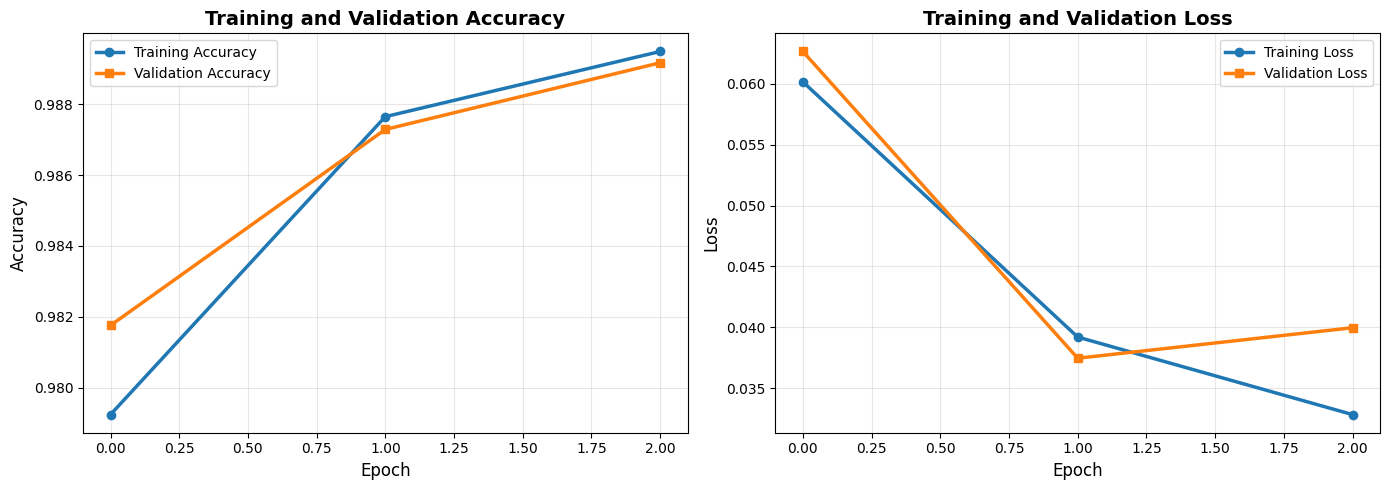

✓ Training history plot saved to results/mbert_training_history.png


In [17]:
# Create results directory
os.makedirs('results', exist_ok=True)

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2.5, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2.5, marker='s')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2.5, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2.5, marker='s')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/mbert_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved to results/mbert_training_history.png")

## 18. Generate Predictions on Test Set

In [18]:
# Generate predictions
print("Generating predictions on test set...")
predictions = model.predict(test_inputs, batch_size=32, verbose=0)

# Get predicted labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Get prediction probabilities
probabilities = tf.nn.softmax(predictions.logits).numpy()
positive_class_probs = probabilities[:, 1]  # Probability for AI class

print(f"✓ Predictions generated for {len(predicted_labels)} samples")
print(f"\nPrediction distribution:")
print(f"  HUMAN: {np.sum(predicted_labels == 0)}")
print(f"  AI: {np.sum(predicted_labels == 1)}")

Generating predictions on test set...
✓ Predictions generated for 9048 samples

Prediction distribution:
  HUMAN: 4905
  AI: 4143


## 19. Confusion Matrix

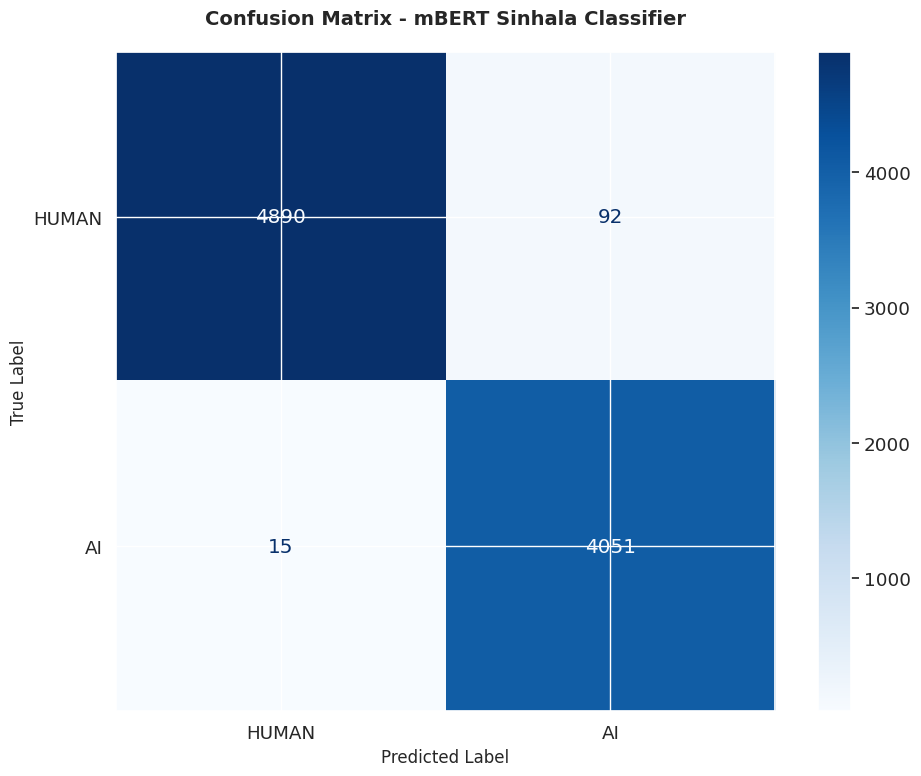

✓ Confusion matrix saved to results/mbert_confusion_matrix.png

Confusion Matrix:
True Negatives (HUMAN->HUMAN): 4890
False Positives (HUMAN->AI): 92
False Negatives (AI->HUMAN): 15
True Positives (AI->AI): 4051


In [ ]:
# Generate confusion matrix with detailed analysis
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['HUMAN', 'AI']
)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title('Confusion Matrix - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('results/mbert_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved to results/mbert_confusion_matrix.png")

# Print confusion matrix values with percentages
total = cm.sum()
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*60)
print("Confusion Matrix Analysis")
print("="*60)
print(f"True Negatives (HUMAN→HUMAN): {tn:4d} ({tn/total*100:.1f}%)")
print(f"False Positives (HUMAN→AI):   {fp:4d} ({fp/total*100:.1f}%)")
print(f"False Negatives (AI→HUMAN):   {fn:4d} ({fn/total*100:.1f}%)")
print(f"True Positives (AI→AI):       {tp:4d} ({tp/total*100:.1f}%)")
print("="*60)

# Calculate error rates
print(f"\nError Analysis:")
print(f"  False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
print(f"  False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")
print(f"  Misclassification Rate: {(fp+fn)/total:.4f} ({(fp+fn)/total*100:.2f}%)")

# Identify most common error
if fp > fn:
    print(f"  ⚠️ Model tends to over-predict AI (more false positives)")
elif fn > fp:
    print(f"  ⚠️ Model tends to under-predict AI (more false negatives)")
else:
    print(f"  ✓ Balanced error distribution")

## 20. ROC Curve and AUC Score

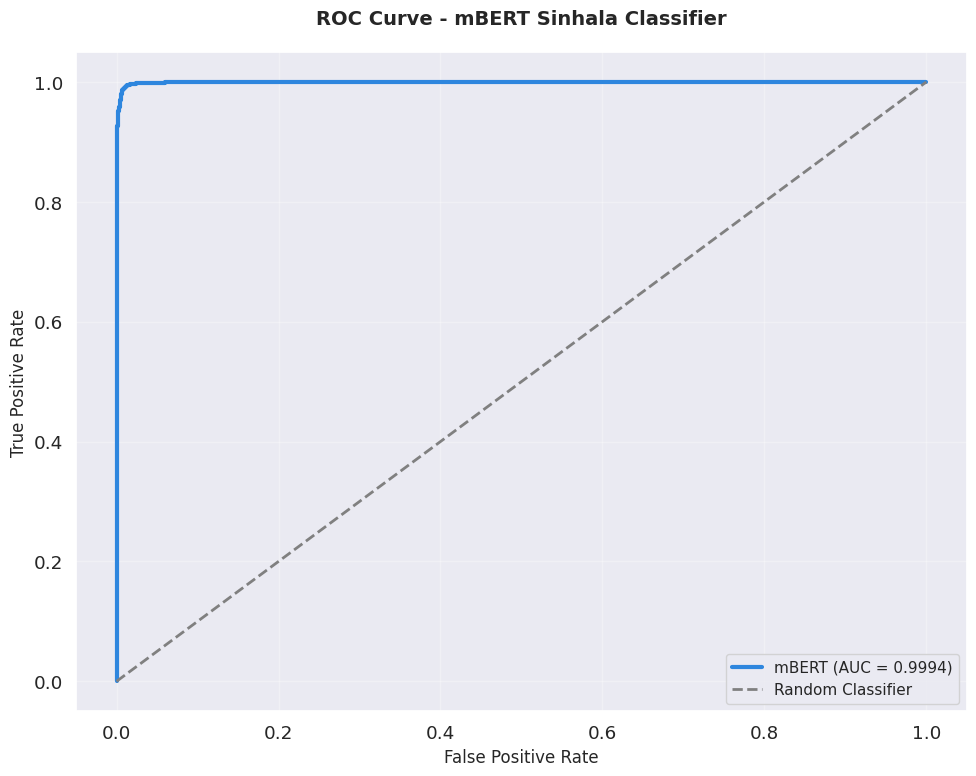

✓ ROC curve saved to results/mbert_roc_curve.png

AUC Score: 0.9994


In [ ]:
# Calculate ROC curve and AUC with improved diagnostics
from sklearn.preprocessing import label_binarize

# Ensure probabilities are numpy arrays
if hasattr(positive_class_probs, 'numpy'):
    probs_np = positive_class_probs.numpy()
else:
    probs_np = np.array(positive_class_probs)

# Clip probabilities to valid range
probs_np = np.clip(probs_np, 0, 1)

# For binary classification, determine which class is AI
ai_class_idx = label_mapping['AI']  # Should be 1
human_class_idx = label_mapping['HUMAN']  # Should be 0

print(f"AI index: {ai_class_idx}, HUMAN index: {human_class_idx}")
print(f"Probability range: [{probs_np.min():.6f}, {probs_np.max():.6f}]")
print(f"Mean prob when true=AI:    {probs_np[test_labels == ai_class_idx].mean():.6f}")
print(f"Mean prob when true=HUMAN: {probs_np[test_labels == human_class_idx].mean():.6f}")
print(f"Unique probability values: {len(np.unique(probs_np))}")

# Calculate ROC curve using AI as positive class
fpr, tpr, thresholds = roc_curve(
    y_true=test_labels,
    y_score=probs_np,
    pos_label=ai_class_idx
)
auc_score = roc_auc_score(test_labels, probs_np)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'mBERT (AUC = {auc_score:.4f})', linewidth=3, color='#2E86DE')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('results/mbert_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ ROC curve saved to results/mbert_roc_curve.png")
print(f"\nAUC Score: {auc_score:.4f}")

# Additional diagnostics
print(f"\nROC Curve Diagnostics:")
print(f"  Number of thresholds: {len(thresholds)}")
print(f"  Threshold range: [{thresholds.min():.6f}, {thresholds.max():.6f}]")
print(f"  Best threshold (Youden's J): {thresholds[np.argmax(tpr - fpr)]:.6f}")

## 21. Precision-Recall Curve

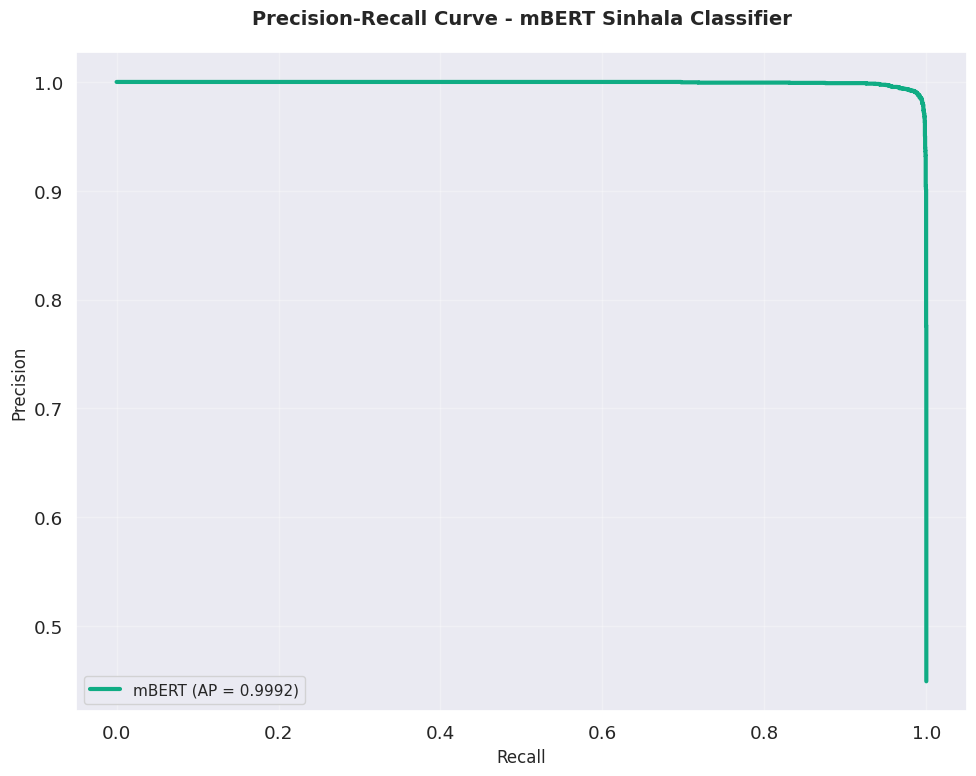

✓ Precision-Recall curve saved to results/mbert_precision_recall_curve.png

Average Precision Score: 0.9992


In [21]:
# Calculate precision-recall curve
from sklearn.metrics import average_precision_score

precision, recall, pr_thresholds = precision_recall_curve(test_labels, positive_class_probs)
avg_precision = average_precision_score(test_labels, positive_class_probs)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, linewidth=3, color='#10AC84', label=f'mBERT (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - mBERT Sinhala Classifier', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/mbert_precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Precision-Recall curve saved to results/mbert_precision_recall_curve.png")
print(f"\nAverage Precision Score: {avg_precision:.4f}")

## 22. Classification Report

In [22]:
# Generate classification report
report = classification_report(
    test_labels,
    predicted_labels,
    target_names=['HUMAN', 'AI'],
    digits=4
)

print("\n" + "="*70)
print("CLASSIFICATION REPORT - TEST SET")
print("="*70)
print(report)
print("="*70)

# Save report to file
with open('results/mbert_classification_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("CLASSIFICATION REPORT - mBERT Sinhala Classifier\n")
    f.write("="*70 + "\n\n")
    f.write(report)
    f.write("\n" + "="*70)

print("\n✓ Classification report saved to results/mbert_classification_report.txt")


CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

       HUMAN     0.9969    0.9815    0.9892      4982
          AI     0.9778    0.9963    0.9870      4066

    accuracy                         0.9882      9048
   macro avg     0.9874    0.9889    0.9881      9048
weighted avg     0.9883    0.9882    0.9882      9048


✓ Classification report saved to results/mbert_classification_report.txt


## 23. Detailed Performance Metrics

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Class-specific metrics
precision_per_class = precision_score(test_labels, predicted_labels, average=None)
recall_per_class = recall_score(test_labels, predicted_labels, average=None)
f1_per_class = f1_score(test_labels, predicted_labels, average=None)

# Create summary DataFrame
metrics_summary = pd.DataFrame({
    'Metric': [
        'Test Accuracy',
        'Test Loss',
        'AUC Score',
        'Average Precision',
        'Weighted Precision',
        'Weighted Recall',
        'Weighted F1-Score',
        'HUMAN - Precision',
        'HUMAN - Recall',
        'HUMAN - F1-Score',
        'AI - Precision',
        'AI - Recall',
        'AI - F1-Score'
    ],
    'Value': [
        f'{accuracy:.4f}',
        f'{test_loss:.4f}',
        f'{auc_score:.4f}',
        f'{avg_precision:.4f}',
        f'{precision:.4f}',
        f'{recall:.4f}',
        f'{f1:.4f}',
        f'{precision_per_class[0]:.4f}',
        f'{recall_per_class[0]:.4f}',
        f'{f1_per_class[0]:.4f}',
        f'{precision_per_class[1]:.4f}',
        f'{recall_per_class[1]:.4f}',
        f'{f1_per_class[1]:.4f}'
    ]
})

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(metrics_summary.to_string(index=False))
print("="*60)

# Save metrics
metrics_summary.to_csv('results/mbert_performance_metrics.csv', index=False)
print("\n✓ Metrics saved to results/mbert_performance_metrics.csv")


DETAILED PERFORMANCE METRICS
            Metric  Value
     Test Accuracy 0.9882
         Test Loss 0.0359
         AUC Score 0.9994
 Average Precision 0.9992
Weighted Precision 0.9883
   Weighted Recall 0.9882
 Weighted F1-Score 0.9882
 HUMAN - Precision 0.9969
    HUMAN - Recall 0.9815
  HUMAN - F1-Score 0.9892
    AI - Precision 0.9778
       AI - Recall 0.9963
     AI - F1-Score 0.9870

✓ Metrics saved to results/mbert_performance_metrics.csv


## 24. Test Model on Sample Texts

In [ ]:
def predict_text(text, model, tokenizer, max_length=256):
    """
    Predict if a given text is HUMAN or AI-generated.
    Returns prediction and confidence score.
    """
    # Preprocess text
    processed_text = preprocess_sinhala_text(text)

    # Tokenize
    encoding = tokenizer(
        [processed_text],
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

    # Predict
    outputs = model(encoding)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]

    predicted_label = np.argmax(probs)
    confidence = probs[predicted_label]

    return {
        'label': reverse_mapping[predicted_label],
        'confidence': float(confidence),
        'human_prob': float(probs[0]),
        'ai_prob': float(probs[1])
    }

# Test on sample texts from test set
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

sample_indices = np.random.choice(len(test_df), 5, replace=False)

correct_predictions = 0
for i, idx in enumerate(sample_indices, 1):
    text = test_df.iloc[idx]['text']
    true_label = test_df.iloc[idx]['label']

    result = predict_text(text, model, tokenizer, MAX_LENGTH)
    is_correct = result['label'] == true_label
    correct_predictions += is_correct

    status = "✓" if is_correct else "✗"
    print(f"\n{status} Sample {i}:")
    print(f"Text: {text[:100]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {result['label']} (Confidence: {result['confidence']:.2%})")
    print(f"  HUMAN: {result['human_prob']:.2%} | AI: {result['ai_prob']:.2%}")
    print("-" * 70)

print(f"\nSample Accuracy: {correct_predictions}/{len(sample_indices)} ({correct_predictions/len(sample_indices)*100:.1f}%)")


SAMPLE PREDICTIONS

Text: නීති විරෝධී ආකාරයට, වලංගු බලපත්‍රයක් නොමැතිව මැදපෙරදිග රැකියා ලබාදෙන බව පවසමින් මුදල් එක් රැස් කළ පු...
True Label: HUMAN
Predicted: HUMAN (Confidence: 99.91%)
  HUMAN: 99.91% | AI: 0.09%
----------------------------------------------------------------------

Text: ශ්‍රී ලංකාවේ වෛද්‍ය ක්ෂේත්‍රයේ පවතින තදබදය හා එහි ඇති වන ගැටුම් සම්බන්ධයෙන් වෛද්‍යවරුන්ගේ ඉවසීමේ ගුණ...
True Label: AI
Predicted: AI (Confidence: 98.94%)
  HUMAN: 1.06% | AI: 98.94%
----------------------------------------------------------------------

Text: ශ්‍රී ලංකාවට පැමිණි හිටපු ඇමති අමල් රාජපක්ෂ ඇතුළු පුද්ගලයින් හය දෙනෙකු රට තුළට ඇතුළු වීම ගැන විවිධ ම...
True Label: AI
Predicted: AI (Confidence: 97.37%)
  HUMAN: 2.63% | AI: 97.37%
----------------------------------------------------------------------

Text: හිටපු ජනාධිපති ගෝඨාභය රාජපක්ෂ මහතා ඉදිරි ජනාධිපතිවරණයට තරග කිරීමට තමන්ට අවශ්‍යතාවයක් නොමැති බව ප්‍රක...
True Label: AI
Predicted: AI (Confidence: 99.52%)
  HUMAN: 0.48% | AI: 99.52%
-----

## 25. Model Summary and Comparison

In [25]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 72,364 samples
  Validation: 9,045 samples
  Test: 9,048 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.9882 (98.82%)
  Test Loss: 0.0359
  AUC Score: 0.9994
  Average Precision: 0.9992
  F1-Score: 0.9882

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!


In [26]:
import shutil
from google.colab import files

# Define paths
folder_path = 'models/mbert_sinhala_classifier'
output_filename = 'mbert_sinhala_classifier'

# Zip the folder
shutil.make_archive(output_filename, 'zip', folder_path)
print(f"Zipped {folder_path} to {output_filename}.zip")

# Download the zip file
files.download(f"{output_filename}.zip")

Zipped models/mbert_sinhala_classifier to mbert_sinhala_classifier.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 72,364 samples
  Validation: 9,045 samples
  Test: 9,048 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.9882 (98.82%)
  Test Loss: 0.0359
  AUC Score: 0.9994
  Average Precision: 0.9992
  F1-Score: 0.9882

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!


In [ ]:
# Final summary
print("\n" + "="*70)
print("mBERT SINHALA CLASSIFIER - FINAL SUMMARY")
print("="*70)
print(f"\nModel: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"\nDataset Sizes:")
print(f"  Training: {len(train_df):,} samples")
print(f"  Validation: {len(val_df):,} samples")
print(f"  Test: {len(test_df):,} samples")
print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {TRAIN_BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  AUC Score: {auc_score:.4f}")
print(f"  Average Precision: {avg_precision:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"\nModel saved to: {MODEL_SAVE_PATH}")
print("="*70)

print("\n✓ All tasks completed successfully!")


mBERT SINHALA CLASSIFIER - FINAL SUMMARY

Model: bert-base-multilingual-cased
Parameters: 177,854,978
Max Sequence Length: 256

Dataset Sizes:
  Training: 72,364 samples
  Validation: 9,045 samples
  Test: 9,048 samples

Training Configuration:
  Epochs: 3
  Batch Size: 16
  Learning Rate: 2e-05

Performance:
  Test Accuracy: 0.9882 (98.82%)
  Test Loss: 0.0359
  AUC Score: 0.9994
  Average Precision: 0.9992
  F1-Score: 0.9882

Model saved to: models/mbert_sinhala_classifier/

✓ All tasks completed successfully!
